# Settings

In [113]:

import os
import sys

from google.colab import drive
drive.mount('/content/drive')  ## connect to personal google drive to use as a working directory

wd_path='/content/drive/MyDrive/cod/unioviedo_assessment' # establish folder in drive as a working directory and add it to the system path

os.chdir(wd_path)
sys.path.append(wd_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [166]:
#### Libraries to use ####################

import numpy as np
import pandas as pd
import random


##############Sklearn fucntions
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
### explanations
import shap

#####NN
import tensorflow as tf


##### for graph ##########
import matplotlib.pyplot as plt
import seaborn as sns


### others

import joblib

In [115]:
#### to asure reproducibility
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


# Section 2: Practical question I

## 1.Simulated data

This synthetic dataset contains independent patient features recorded in **January 2024**, including:

- Age  
- BMI  
- Fasting Glucose  
- HbA1c  
- Blood Pressure  
- Cholesterol  
- Physical Activity  
- Family History  
- Smoking Status  
- Diet Quality  

The **dependent variable** is a **binary target** indicating whether the patient develops diabetes by **January 2025**, calculated as follows:

- `1`: *Diabetes onset* — if fasting glucose ≥ 126 mg/dL  
- `0`: *No diabetes onset* — if fasting glucose < 126 mg/dL  

To ensure realistic patterns between features and the target, labels were generated using a neural network trained on the structured input features. This avoids a fully random assignment of labels, which would produce purely stochastic results and prevent meaningful prediction.

> **Note:** This is a **simplified scenario** where the data source is entirely **structured** and **transversal** (non-longitudinal), developed under time constraints for assessment purposes.


In [116]:
#### simulate Independent features
####

num_samples = 5000

# Generating independent input features for January 2024
features_2024 = pd.DataFrame({
    'age' : np.random.randint(30, 80, size=num_samples),
    'bmi' : np.round(np.random.uniform(18, 40, size=num_samples), 1),
    'fasting_glucose' : np.round(np.random.uniform(80, 160, size=num_samples), 1),
    'hba1c' : np.round(np.random.uniform(4.5, 8.0, size=num_samples), 1),
    'blood_pressure' : np.round(np.random.uniform(110, 160, size=num_samples), 0),
    'cholesterol' : np.round(np.random.uniform(150, 280, size=num_samples), 1),
    'physical_activity' : np.random.choice([0, 1], size=num_samples, p=[0.5, 0.5]),
    'family_history' : np.random.choice([0, 1], size=num_samples, p=[0.7, 0.3]),
    'smoking_status' : np.random.choice(['never', 'former', 'current'], size=num_samples, p=[0.6, 0.25, 0.15]),
    'diet_quality' : np.random.choice(['poor', 'average', 'good'], size=num_samples, p=[0.3, 0.5, 0.2])


})



##### Apply ordinal encoder given that both cathegorical variable have a sense of order, so it is better option the one-hotencoder
features_2024_encode = features_2024.copy()

# Define the correct order for each ordinal variable
ordinal_categories = {
    'smoking_status': ['never', 'former', 'current'],  # Ordered from lowest to highest
    'diet_quality': ['poor', 'average', 'good']       # Ordered from worst to best
}

# Initialize the encoder with specified category order
encoder = OrdinalEncoder(
    categories=[ordinal_categories[col] for col in ['smoking_status', 'diet_quality']],
    dtype=int  # Output integers instead of floats
)

# Apply encoding (preserves order)
features_2024_encode[['smoking_status', 'diet_quality']] = encoder.fit_transform(
    features_2024[['smoking_status', 'diet_quality']]
)


In [117]:
#### create dependent feature based on input features and adding randomnes ####

tf.config.experimental.enable_op_determinism() ### garantee reproductibility in creation of neural network

# Neural Network model
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(features_2024.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu', ),
    tf.keras.layers.Dense(16, activation='relu', ),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Use deterministic Adam optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

# Generate synthetic labels with fixed seed

y_synthetic = (np.random.rand(len(features_2024_encode)) > 0.5).astype(int)

# Fit model with deterministic settings
model.fit(features_2024_encode, y_synthetic,
          epochs=5,
          batch_size=32,
          verbose=0,
          shuffle=False)  # Disable shuffling for reproducibility

# Predict diabetes onset with fixed randomness

diabetes_prob = model.predict(features_2024_encode)

# Add small uniform noise to introduce randomness
noise = np.random.uniform(-0.1, 0.1, size=diabetes_prob.shape)
diabetes_prob_perturbed = diabetes_prob + noise

# Clip to keep within [0, 1] range
diabetes_prob_perturbed = np.clip(diabetes_prob_perturbed, 0, 1)

# Apply threshold to get binary outcome
diabetes_2025 = (diabetes_prob_perturbed >= 0.5).astype(int)
print(diabetes_prob ) ## verify reproducibility

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[0.6543342 ]
 [0.6210191 ]
 [0.5525774 ]
 ...
 [0.576343  ]
 [0.56305015]
 [0.5526559 ]]


In [118]:
## Create the full dataset to convert in csv
df_diabetes = features_2024.copy()
df_diabetes['diabetes_2025'] = diabetes_2025

df_diabetes.to_csv('df_diabetes.csv', index=False)

##########
print(df_diabetes.head())
print(df_diabetes.info())



   age   bmi  fasting_glucose  hba1c  blood_pressure  cholesterol  \
0   75  25.6            110.7    6.3           134.0        153.8   
1   32  28.2            131.4    6.3           155.0        214.2   
2   58  32.6            112.7    6.8           113.0        266.5   
3   64  23.0            100.4    4.8           140.0        259.7   
4   68  33.8             81.0    6.4           136.0        259.7   

   physical_activity  family_history smoking_status diet_quality  \
0                  1               0          never         good   
1                  0               0          never         good   
2                  0               0          never         poor   
3                  0               0          never         good   
4                  0               0          never         poor   

   diabetes_2025  
0              1  
1              1  
2              0  
3              0  
4              1  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries

## 2.Preprocessing Pipeline

In [279]:
df_diabetes = pd.read_csv('df_diabetes.csv')
print(df_diabetes.info())

bin_feat=['physical_activity', 'family_history']
obj_feat = df_diabetes.select_dtypes(include=['object']).columns.tolist()
cont_feat = df_diabetes.drop(columns=['diabetes_2025'] + bin_feat).select_dtypes(include=['int64', 'float64']).columns.tolist()



### train test split, test for evaluate after hyperparameter tunning and x include validation sample to performe cross validation
X = df_diabetes.drop('diabetes_2025', axis=1)
y = df_diabetes['diabetes_2025']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


,age,bmi,fasting_glucose,hba1c,blood_pressure,cholesterol,physical_activity,family_history,smoking_status,diet_quality
0,75,25.6,110.7,6.3,134.0,153.8,1,0,never,good
1,32,28.2,131.4,6.3,155.0,214.2,0,0,never,good
2,58,32.6,112.7,6.8,113.0,266.5,0,0,never,poor
3,64,23.0,100.4,4.8,140.0,259.7,0,0,never,good
4,68,33.8,81.0,6.4,136.0,259.7,0,0,never,poor
...,...,...,...,...,...,...,...,...,...,...
4995,42,27.1,101.2,4.9,112.0,240.7,1,1,never,average
4996,55,21.0,88.9,5.1,145.0,174.2,1,1,never,average
4997,31,32.9,91.5,5.2,150.0,206.8,1,1,never,poor
4998,74,28.9,92.5,4.9,144.0,242.4,0,0,never,poor


In [140]:
### pipeline with preprocessing

ordinal_categories = {
    'smoking_status': ['never', 'former', 'current'],
    'diet_quality': ['poor', 'average', 'good']
}

# Create the encoder with ordered categories
encoder = OrdinalEncoder(
    categories=[ordinal_categories[col] for col in ['smoking_status', 'diet_quality']],
    dtype=int
)

## given there are few features the threshold is soft to avoid delete many features
feature_selector = SelectFromModel(estimator=RandomForestClassifier(n_estimators=100, random_state=SEED),threshold="0.1*mean")


# Define the object transformer pipeline
obj_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', encoder)
])

cont_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

bin_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))
])


# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cont', cont_transformer, cont_feat),
        ('obj', obj_transformer, obj_feat),
        ('bin',bin_transformer, bin_feat)
    ])



pip_prepro = Pipeline([
    ('preprocessor', preprocessor),             # Your ColumnTransformer
    ('feature_selection', feature_selector)
])



## 3.Compairing models (standar hyperparameter)

In [141]:
### utils function

import pandas as pd
from sklearn.model_selection import  cross_val_score

def compair_models(modelos, scoring, X, y, cv):
    metric_modelos = pd.DataFrame()

    for modelo in modelos:
        # Get a clean model name (e.g., 'LogisticRegression')
        model_name = type(modelo.named_steps['classifier']).__name__

        # Cross-validation scores
        scores = cross_val_score(modelo, X, y, scoring=scoring, cv=cv)

        # Add scores to the DataFrame as a new column
        metric_modelos[model_name] = scores

    return metric_modelos

In [142]:
from sklearn import linear_model, tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

m_lreg = linear_model.LogisticRegression(max_iter=1000, random_state=SEED)

# Decision Tree Classifier
m_rtree = tree.DecisionTreeClassifier(
    criterion='gini',
    max_depth=None,
    min_samples_split=2,
    random_state=42
)

# Random Forest Classifier
m_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)

# Gradient Boosting Classifier
m_gbt = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=1.0,
    random_state=42
)

modelos = [
    Pipeline([
        ('preprocessor', pip_prepro),
        ('classifier', m_lreg)
    ]),
    Pipeline([
        ('preprocessor',pip_prepro),
        ('classifier', m_rtree)
    ]),
    Pipeline([
        ('preprocessor', pip_prepro),
        ('classifier', m_rf)
    ]),
    Pipeline([
        ('preprocessor', pip_prepro),
        ('classifier', m_gbt)
    ])
]




In [288]:
# Fit search
feature_names_in = X.columns
X_train_df=pd.DataFrame(X_train, columns=feature_names_in, index=X_train.index)
X_test_df=pd.DataFrame(X_test, columns=feature_names_in, index=X_test.index)

results_df = compair_models(modelos, scoring='accuracy', X=X_train_df, y=y_train, cv=10)
results_df


,LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,GradientBoostingClassifier
0,0.9150,0.8625,0.9100,0.9100
1,0.9150,0.8575,0.9175,0.9125
2,0.9150,0.8700,0.9150,0.9150
3,0.9125,0.8425,0.9150,0.9150
4,0.9025,0.8350,0.9025,0.8950
5,0.9075,0.8650,0.9150,0.9225
6,0.9225,0.8575,0.9150,0.9150
7,0.9200,0.8650,0.9175,0.9150
8,0.9100,0.8225,0.9050,0.9125
9,0.9025,0.8625,0.9050,0.8975


In [289]:
mean_table = results_df.mean().reset_index(name='Mean').rename(columns={'index': 'Model'})
mean_table=mean_table.sort_values(by='Mean', ascending=False)
mean_table

,Model,Mean
0,LogisticRegression,0.91225
2,RandomForestClassifier,0.91175
3,GradientBoostingClassifier,0.91100
1,DecisionTreeClassifier,0.85400


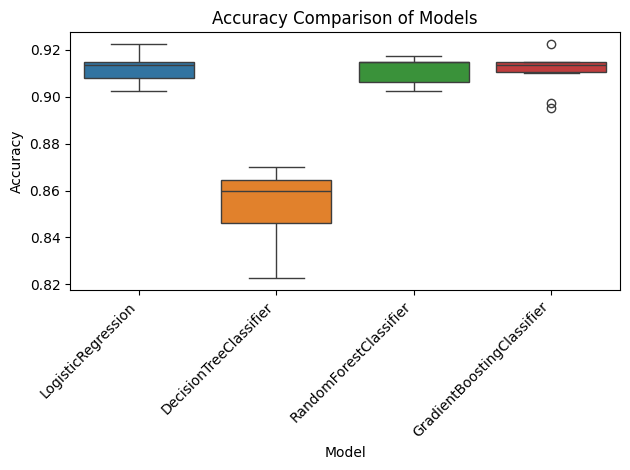

In [290]:

# Create the boxplot
sns.boxplot(data=results_df)
plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Models')
plt.tight_layout()
plt.show()



## 4.Model Selection and hyperparmeter tunning


Although the performance differences between Logistic Regression, Gradient Boosting, and Random Forest are not statistically significant, Random Forest demonstrates greater stability across validation folds. From a parsimony standpoint, Logistic Regression would typically be preferred due to its simplicity and interpretability. However, in this case, we select Random Forest to enable post-hoc explainability using feature importance and model-agnostic XAI techniques.

In [291]:
### Complete the pipeline with random forest

pipeline = Pipeline([
    ('preprocessor', pip_prepro),
    ('classifier', RandomForestClassifier(random_state=SEED))
])



In [152]:
!pip install --quiet optuna optuna-integration[sklearn]


In [293]:
import optuna
from optuna.integration import OptunaSearchCV
## optimización de hiperparámetros

param_distributions = {
    'classifier__n_estimators': optuna.distributions.IntDistribution(50, 200),
    'classifier__max_depth': optuna.distributions.IntDistribution(3, 20),
    'classifier__min_samples_split': optuna.distributions.IntDistribution(2, 10),
    'classifier__max_features': optuna.distributions.CategoricalDistribution(['sqrt', 'log2', None])
}

# Create the search object
optuna_search = OptunaSearchCV(
    pipeline,
    param_distributions,
    n_trials=10,
    scoring='accuracy',
    cv=5,
    random_state=SEED,
    verbose=1
)



optuna_search.fit(X_train_df, y_train)

<ipython-input-293-d3ed7fcff420>:13: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search = OptunaSearchCV(
[I 2025-04-18 21:46:52,028] A new study created in memory with name: no-name-c13f5019-2e30-4616-80f3-0312c69d176f
INFO:optuna_integration.sklearn.sklearn:Searching the best hyperparameters using 4000 samples...
[I 2025-04-18 21:46:59,922] Trial 0 finished with value: 0.9119999999999999 and parameters: {'classifier__n_estimators': 159, 'classifier__max_depth': 13, 'classifier__min_samples_split': 4, 'classifier__max_features': 'log2'}. Best is trial 0 with value: 0.9119999999999999.
[I 2025-04-18 21:47:06,881] Trial 1 finished with value: 0.91225 and parameters: {'classifier__n_estimators': 106, 'classifier__max_depth': 13, 'classifier__min_samples_split': 5, 'classifier__max_features': 'log2'}. Best is trial 1 with value: 0.91225.
[I 2025-04-18 21:47:12,458] Trial 2 finished with value: 0.91175 and p

OptunaSearchCV(cv=5,
               estimator=Pipeline(steps=[('preprocessor',
                                          Pipeline(steps=[('preprocessor',
                                                           ColumnTransformer(transformers=[('cont',
                                                                                            Pipeline(steps=[('imputer',
                                                                                                             SimpleImputer(strategy='median')),
                                                                                                            ('scaler',
                                                                                                             StandardScaler())]),
                                                                                            ['age',
                                                                                             'bmi',
                                                                                             'fasting_glucose',
                                                                                             'hba1c',
                                                                                             'blood_pressure',
                                                                                             'cholesterol']),
                                                                                           ('obj',
                                                                                            Pipeline(steps=[('imputer',
                                                                                                             SimpleImputer(strat...
               param_distributions={'classifier__max_depth': IntDistribution(high=20, log=False, low=3, step=1),
                                    'classifier__max_features': CategoricalDistribution(choices=('sqrt', 'log2', None)),
                                    'classifier__min_samples_split': IntDistribution(high=10, log=False, low=2, step=1),
                                    'classifier__n_estimators': IntDistribution(high=200, log=False, low=50, step=1)},
               random_state=123, scoring='accuracy', verbose=1)

In [294]:


best_model=optuna_search.best_estimator_  ## best model after hypeparameter roptimization
joblib.dump(optuna_search.best_estimator_, 'outputs/best_model.pkl') ## save the model to not having to train again


['outputs/best_model.pkl']

## 5.Model Evaluation

In [295]:
best_model_loaded = joblib.load('outputs/best_model.pkl')


Classification Report (Train):
              precision    recall  f1-score   support

           0       1.00      0.36      0.53       353
           1       0.94      1.00      0.97      3647

    accuracy                           0.94      4000
   macro avg       0.97      0.68      0.75      4000
weighted avg       0.95      0.94      0.93      4000


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.67      0.04      0.08        89
           1       0.91      1.00      0.95       911

    accuracy                           0.91      1000
   macro avg       0.79      0.52      0.52      1000
weighted avg       0.89      0.91      0.88      1000



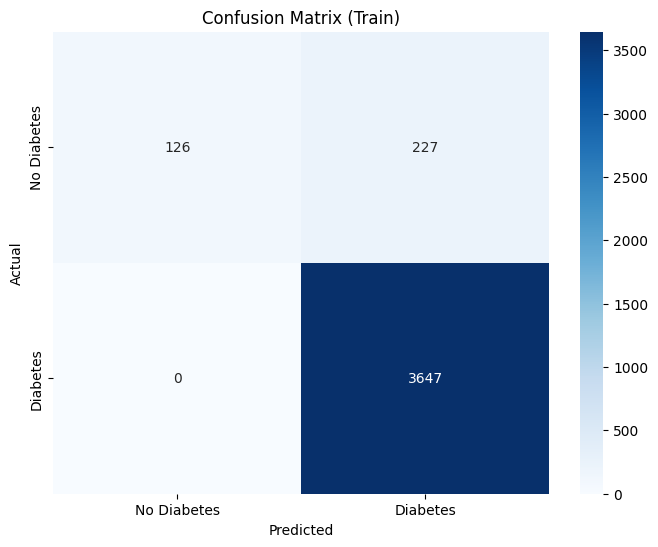

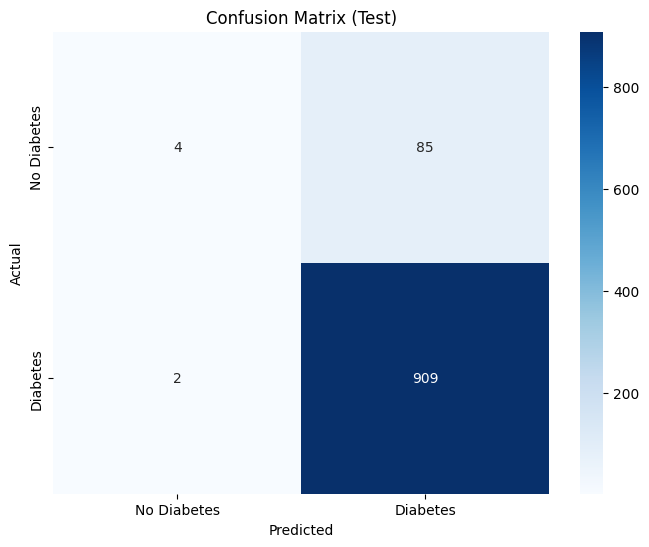

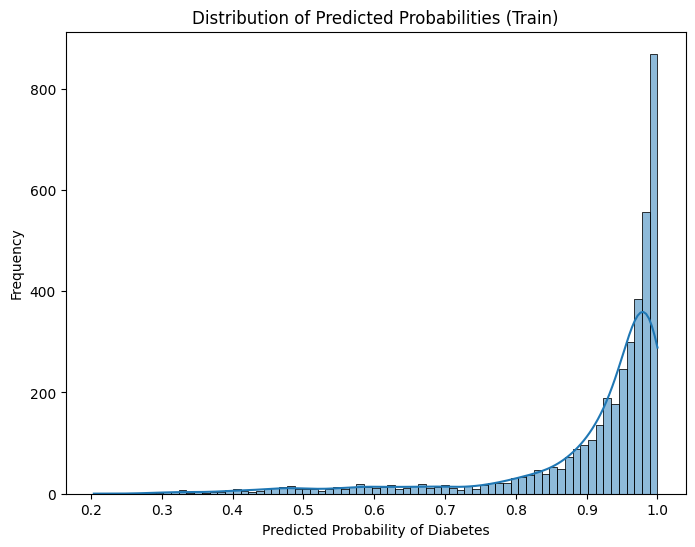

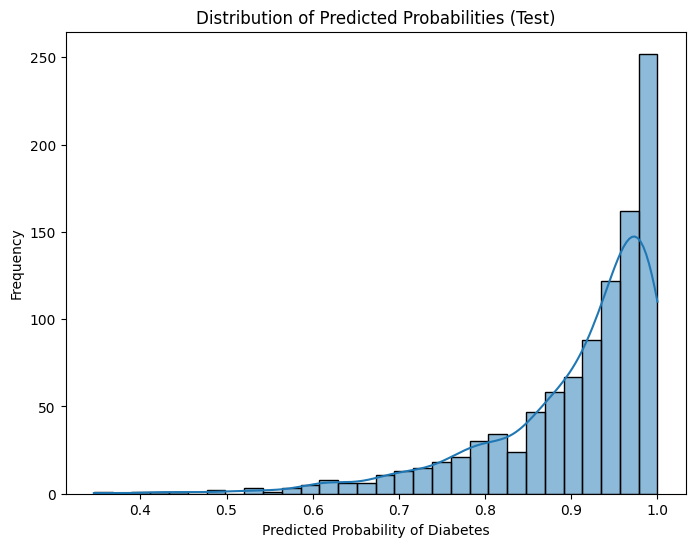

In [296]:
# Predict probabilities for train and test sets
y_train_pred_proba = best_model_loaded.predict_proba(X_train)
y_test_pred_proba = best_model_loaded.predict_proba(X_test)

# Predict classes for train and test sets
y_train_pred = best_model_loaded.predict(X_train)
y_test_pred = best_model_loaded.predict(X_test)

# Classification report for train set
print("Classification Report (Train):")
print(classification_report(y_train, y_train_pred))

# Classification report for test set
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))


# Confusion matrix for train set
cm_train = confusion_matrix(y_train, y_train_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_train, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title("Confusion Matrix (Train)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Confusion matrix for test set
cm_test = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=['No Diabetes', 'Diabetes'],
            yticklabels=['No Diabetes', 'Diabetes'])
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Distribution of probabilities for train set
plt.figure(figsize=(8, 6))
sns.histplot(y_train_pred_proba[:, 1], kde=True)
plt.title("Distribution of Predicted Probabilities (Train)")
plt.xlabel("Predicted Probability of Diabetes")
plt.ylabel("Frequency")
plt.show()

# Distribution of probabilities for test set
plt.figure(figsize=(8, 6))
sns.histplot(y_test_pred_proba[:, 1], kde=True)
plt.title("Distribution of Predicted Probabilities (Test)")
plt.xlabel("Predicted Probability of Diabetes")
plt.ylabel("Frequency")
plt.show()


**Model Evaluation Analysis:**  The classification report shows that the model performs very well on the dominant class (class 1), but fails almost completely on the minority class (class 0). On the training set, class 1 achieves perfect recall (1.00) and a high f1-score (0.97), while class 0 has perfect precision (1.00) but very low recall (0.36), indicating that the model is highly conservative when predicting class 0. On the test set, this imbalance becomes more extreme: class 1 still has perfect recall (1.00) and strong precision (0.91), but class 0 has a recall of only 0.04 and an f1-score of 0.08. This means the model is almost never identifying class 0 correctly.

Although the overall accuracy is high (91%), it is misleading due to the heavy class imbalance. The macro average f1-score on the test set is only 0.52, reflecting poor overall balance between classes.

In summary, the model is highly biased toward class 1 and performs poorly on class 0. This suggests that addressing class imbalance—through class weighting, resampling techniques like SMOTE, or threshold tuning—is necessary to improve performance and ensure the model is useful in detecting both classes. This balancing issues were not addressed due to time constraints.

## 6.Model explanations

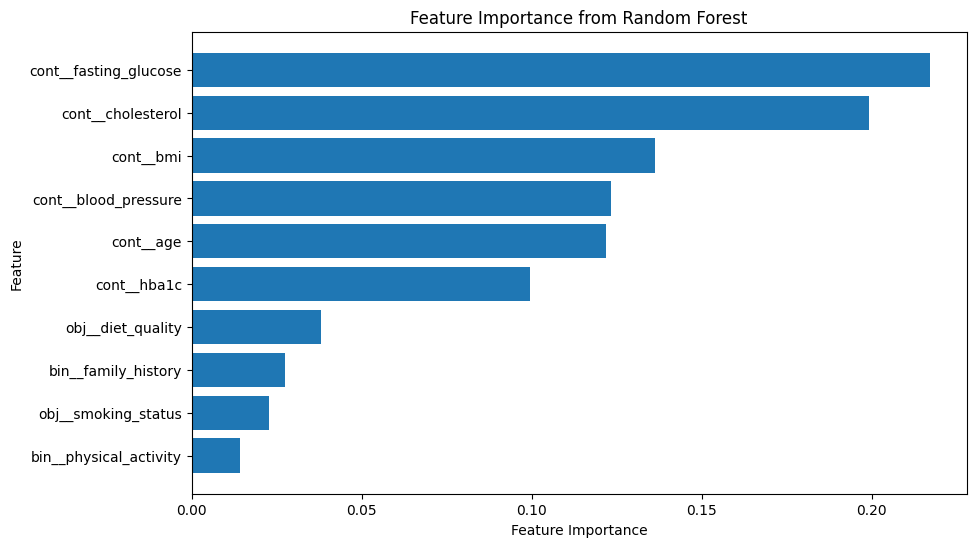

In [297]:
## Gloabal explanation based on Random Forest

importances = best_model_loaded.named_steps['classifier'].feature_importances_

# Get feature names after preprocessing
feature_names = best_model_loaded.named_steps['preprocessor'].get_feature_names_out()

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


# Plotting
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance from Random Forest')
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


In [311]:
# separate model from preprocessing and fucntion to extract proabbility of label 1
model=best_model_loaded.named_steps['classifier']
prepro=best_model_loaded.named_steps['preprocessor']

feat_names=prepro.get_feature_names_out()
x_train_prepro = prepro.transform(X_train)
x_test_prepro = prepro.transform(X_test)

x_train_prepro_df=pd.DataFrame(x_train_prepro, columns=feat_names, index=X_train.index)
x_test_prepro_df=pd.DataFrame(x_test_prepro, columns=feat_names, index=X_test.index)

def pred_1_label(x):
  return model.predict_proba(x)[:,1]

In [314]:
import warnings
explainer=shap.Explainer(pred_1_label, x_train_prepro_df)



with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    shap_values = explainer(x_test_prepro_df.iloc[0:100, :])

ExactExplainer explainer: 101it [00:36,  2.20it/s]


In [ ]:
### global explanations

<ipython-input-315-6bbe1e2a5879>:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, x_test_prepro, plot_type="bar", feature_names=prepro.get_feature_names_out())


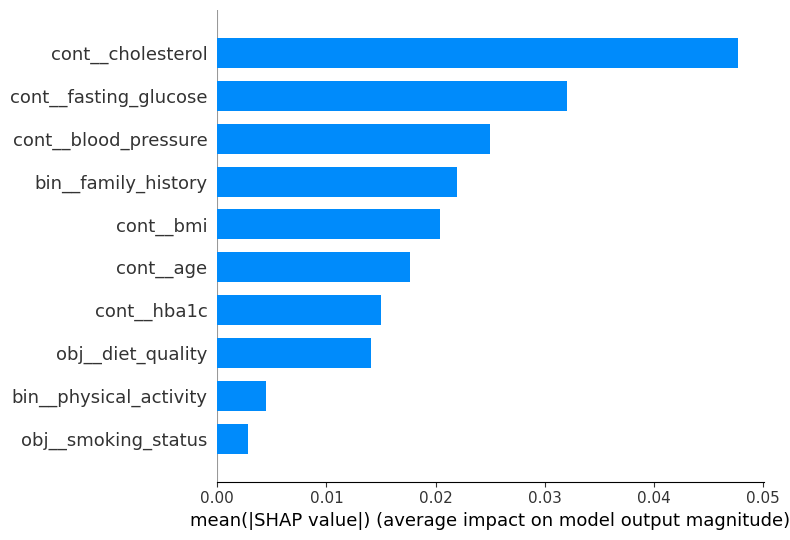

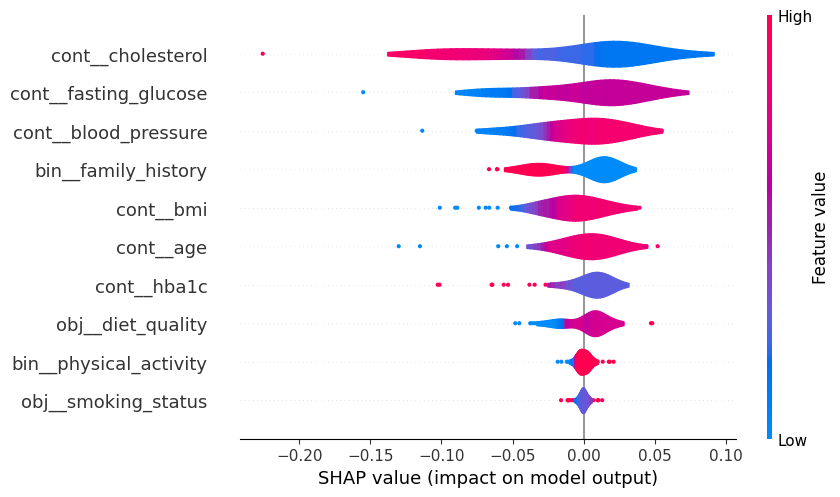

In [315]:
shap.summary_plot(shap_values, x_test_prepro, plot_type="bar", feature_names=prepro.get_feature_names_out())
shap.plots.violin(shap_values, feature_names=prepro.get_feature_names_out())


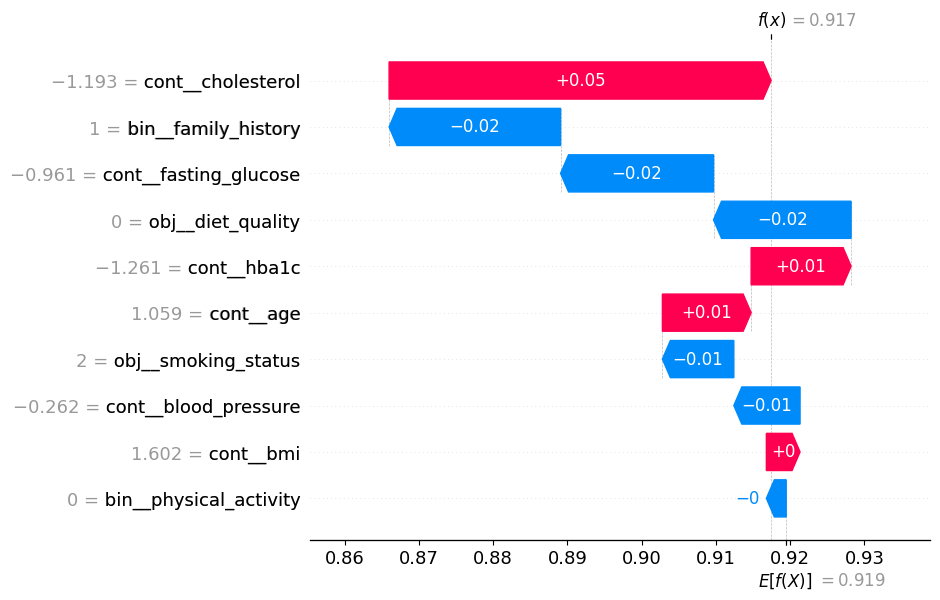

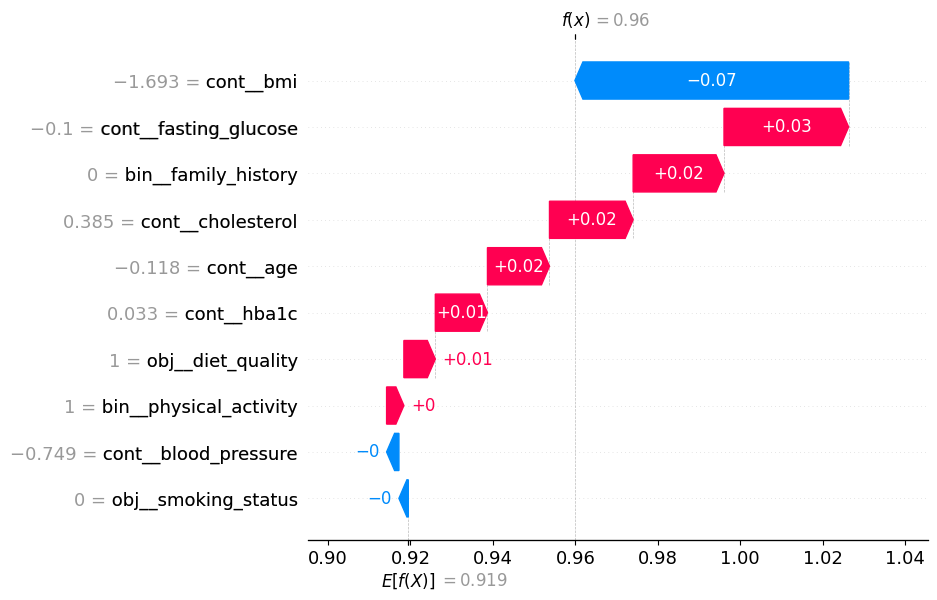

In [316]:
### local explanations ####
shap.plots.waterfall(shap_values[0])
shap.plots.waterfall(shap_values[1])

## 7.Robustness

In [341]:
# Select a few test samples
X_eval = X_test_df.sample(n=100, random_state=SEED)
original_preds = best_model.predict(X_eval)

# Define noise function
def add_noise(X, noise_level=0.1):
    noisy = X.copy()
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    noise = np.random.normal(loc=0, scale=noise_level, size=X[numeric_cols].shape)
    noisy[numeric_cols] += noise
    return noisy

# Define outlier injection function (boost values massively)
def add_outliers(X, multiplier=10):
    outliers = X.copy()
    numeric_cols = X.select_dtypes(include=[np.number]).columns
    outliers[numeric_cols] = outliers[numeric_cols] * multiplier
    return outliers

# Evaluate on noisy and outlier-affected data
X_noise = add_noise(X_eval)
X_outlier = add_outliers(X_eval)

preds_noise = best_model.predict(X_noise)
preds_outlier = best_model.predict(X_outlier)
probs_original = best_model.predict_proba(X_eval)[:, 1]
probs_noise = best_model.predict_proba(X_noise)[:, 1]
probs_outlier = best_model.predict_proba(X_outlier)[:, 1]

# Add to DataFrame
robustness_df['Prob_Original'] = probs_original
robustness_df['Prob_Noise'] = probs_noise
robustness_df['Prob_Outlier'] = probs_outlier

# Display changes
robustness_df = pd.DataFrame({
    "Original Prediction": original_preds,
    "With Noise": preds_noise,
    "With Outliers": preds_outlier,
    "Prob_Original": probs_original,
    "Prob_Noise": probs_noise,
    "Prob_Outlier": probs_outlier
})

robustness_df['Delta_Prob_Noise'] = np.abs(robustness_df['Prob_Original'] - robustness_df['Prob_Noise'])
robustness_df['Delta_Prob_Outlier'] = np.abs(robustness_df['Prob_Original'] - robustness_df['Prob_Outlier'])


flip_noise = (robustness_df['Original Prediction'] != robustness_df['With Noise']).mean()
flip_outlier = (robustness_df['Original Prediction'] != robustness_df['With Outliers']).mean()
mad_noise = robustness_df['Delta_Prob_Noise'].mean()
mad_outlier = robustness_df['Delta_Prob_Outlier'].mean()

# Create transposed DataFrame
robustness_summary_df = pd.DataFrame({
    'Noise': [flip_noise, mad_noise],
    'Outlier': [flip_outlier, mad_outlier]
}, index=['Flip count (%)', 'Mean Absolute delta Prob (%)'])*100

# Display result
robustness_summary_df.round(2)


,Noise,Outlier
Flip count (%),0.00,1.00
Mean Absolute delta Prob (%),0.61,18.67


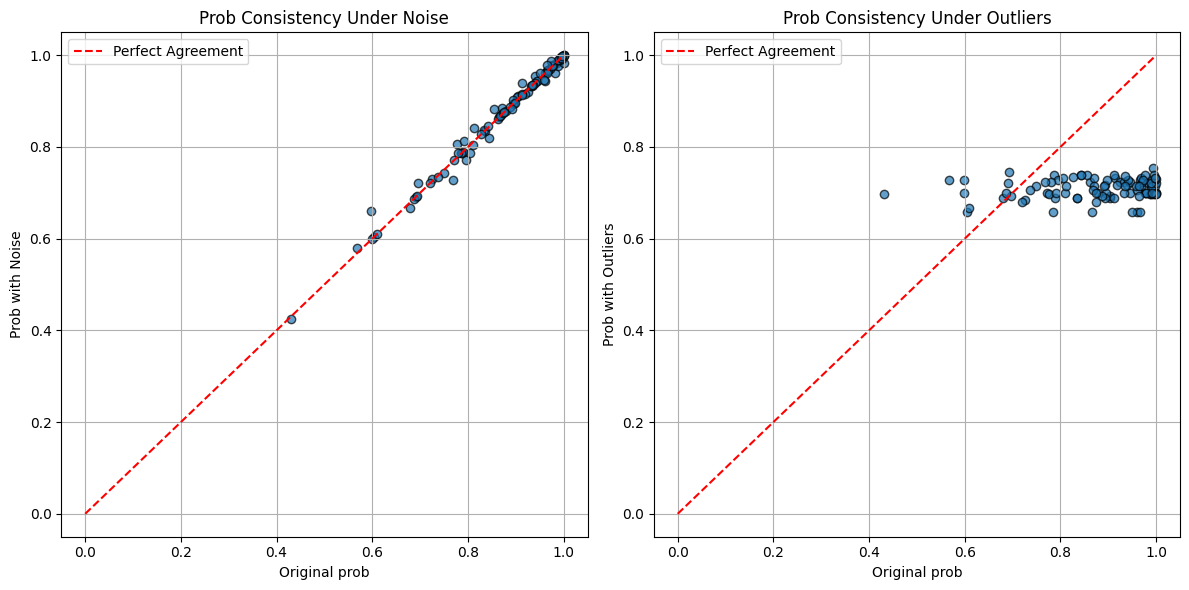

In [345]:
# Create figure with 1 row and 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1: Noise
axes[0].scatter(
    robustness_df["Prob_Original"],
    robustness_df["Prob_Noise"],
    alpha=0.7,
    edgecolors='k'
)
axes[0].plot([0, 1], [0, 1], 'r--', label='Perfect Agreement')
axes[0].set_xlabel("Original prob")
axes[0].set_ylabel("Prob with Noise")
axes[0].set_title("Prob Consistency Under Noise")
axes[0].legend()
axes[0].grid(True)

# Plot 2: Outlier
axes[1].scatter(
    robustness_df["Prob_Original"],
    robustness_df["Prob_Outlier"],
    alpha=0.7,
    edgecolors='k'
)
axes[1].plot([0, 1], [0, 1], 'r--', label='Perfect Agreement')
axes[1].set_xlabel("Original prob")
axes[1].set_ylabel("Prob with Outliers")
axes[1].set_title("Prob Consistency Under Outliers")
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()